In [3]:
import numpy as np
import pandas as pd

from preprocess.preprocess_transaction_frequecy import preprocess_transaction_frequency
from preprocess.preprocess_init import preprocess_init
from preprocess.preprocess_time import preprocess_time
from preprocess.preprocess_change_card import preprocess_change_card
from preprocess.preprocess_mchno import preprocess_mchno
from preprocess.preprocess_special_features import preprocess_special_features
from preprocess.preprocess_conam import preprocess_conam
from preprocess.preprocess_train_test_split import preprocess_train_test_split

from util.generate_X_y import generate_X_y
from util.remove_outlier import remove_outlier
from util.generate_statistic import generate_statistic

from model.lgbm_model import LGBM_Model
from model.shap_importance import shap_importance
from model.plot import plot_importance

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# Define features

In [4]:
raw_bool_features = ['ecfg',
                     'flbmk',
                     'flg_3dsmk',
                     'insfg',
                     'ovrlt'
                      ]

raw_categorial_features = ['contp',
                           'stscd',
                           'etymd',
                           'stocn',
                           'mcc',
                           'csmcu',
                           'hcefg',
                           'bacno',
                           'cano',
                           'mchno',
                           'acqic',
                           'scity'
                            ] 

raw_contiuous_feautres = ['loctm',
                          'conam',
                          'iterm'
                           ]

transaction_frequency_feautres = ['cano_days_txkey_count',
                                  'cano_locdt_txkey_count',
                                  'bacno_locdt_mchno_txkey_count'
                                    ]

time_feautres = ['last_time_days',
                 'next_time_days',
                 'cano_locdt_global_time_std' 
                    ]


change_card_feautres = ['diff_locdt_with_last_trans_cano',
                        'diff_locdt_of_two_card'
                           ]

conam_feautres = ['cano_locdt_conam_min',
                  'cano_locdt_conam_max',
                  'diff_gtime_with_conam_zero_trans_locdt'
                   ]

mchno_features = ['bacno_mchno_locdt_head_tail_diff',
                  'cano_days_mchno_index',    
                    ]


special_feautures = ['mchno_in_normal_mchno_list',
                    'mchno_in_fraud_mchno_list',
                    'conam_in_fraud_conam_list',
                    'diff_with_first_fraud_locdt'
                               ]

base_features =  (    raw_bool_features 
                    + raw_categorial_features
                    + raw_contiuous_feautres
                    + transaction_frequency_feautres
                    + time_feautres
                    + change_card_feautres
                    + conam_feautres 
                    + mchno_features
                       )

label = 'fraud_ind'

# Preprocess

In [6]:
preprocess_group = True
if preprocess_group:
    df_train_raw = pd.read_csv('data/train.csv')
    df_test_raw = pd.read_csv('data/test.csv')
    df = preprocess_init(df_train_raw, df_test_raw, raw_bool_features)
    df = preprocess_transaction_frequency(df)
    df = preprocess_time(df)
    df = preprocess_change_card(df)
    df = preprocess_mchno(df)
    df = preprocess_conam(df)
    df = preprocess_special_features(df)
    df.to_pickle('data/df_preprocessed.pkl')
else:
    df = pd.read_pickle('data/df_preprocessed.pkl')    

# Base features

In [18]:
df_train, df_test = preprocess_train_test_split(df, raw_categorial_features)
input_features = base_features 
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train.tail(10)

,ecfg,flbmk,flg_3dsmk,insfg,ovrlt,contp,stscd,etymd,stocn,mcc,csmcu,hcefg,bacno,cano,mchno,acqic,scity,loctm,conam,iterm,cano_days_txkey_count,cano_locdt_txkey_count,bacno_locdt_mchno_txkey_count,last_time_days,next_time_days,cano_locdt_global_time_std,diff_locdt_with_last_trans_cano,diff_locdt_of_two_card,cano_locdt_conam_min,cano_locdt_conam_max,diff_gtime_with_conam_zero_trans_locdt,bacno_mchno_locdt_head_tail_diff,cano_days_mchno_index
1943429,0,0,0,0,0,5.0,0.0,5.0,102.0,292.0,62.0,5.0,NaN,NaN,47022,6716.0,4526.0,202808.0,815.08,0,9,1,1,99046.0,NaN,NaN,0,NaN,815.08,815.08,NaN,0,1
1943430,1,0,0,0,0,5.0,0.0,8.0,102.0,209.0,62.0,5.0,NaN,NaN,38207,6322.0,5817.0,61702.0,750.24,0,9,3,1,NaN,-46675.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943431,0,0,0,0,0,5.0,0.0,5.0,102.0,270.0,62.0,5.0,NaN,NaN,39044,6716.0,5820.0,191457.0,841.64,0,9,3,1,46675.0,-7720.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943432,0,0,0,0,0,5.0,0.0,5.0,102.0,306.0,62.0,5.0,NaN,NaN,88672,5975.0,5817.0,212337.0,381.65,0,9,3,1,7720.0,-84800.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943433,0,0,0,0,0,5.0,0.0,5.0,102.0,192.0,62.0,5.0,NaN,NaN,NaN,5975.0,5817.0,205657.0,366.38,0,9,1,1,84800.0,-240959.0,NaN,-12,NaN,366.38,366.38,NaN,0,1
1943434,0,0,0,0,0,5.0,0.0,5.0,102.0,288.0,62.0,5.0,NaN,NaN,NaN,5975.0,5817.0,155256.0,1119.11,0,9,4,1,240959.0,-5347.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,1
1943435,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,NaN,NaN,6475,6767.0,5817.0,172203.0,1334.91,0,9,4,3,5347.0,-2025.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,1
1943436,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,NaN,NaN,6475,6767.0,5817.0,175548.0,1125.71,0,9,4,3,2025.0,-735.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,2
1943437,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,NaN,NaN,6475,6767.0,5817.0,180803.0,1103.64,0,9,4,3,735.0,-749289.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,3
1943438,1,0,0,1,0,5.0,0.0,8.0,102.0,247.0,62.0,5.0,NaN,NaN,82174,6769.0,5817.0,101612.0,1194.66,1,9,1,1,749289.0,NaN,NaN,0,NaN,1194.66,1194.66,NaN,0,1


# Base Model

In [7]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 10)

Starting LightGBM. Fold 1,Train shape: (1521787, 33), test shape: (421665, 33)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.791544	valid_1's Averge Precision: 0.644891
[200]	training's Averge Precision: 0.834159	valid_1's Averge Precision: 0.663898
[300]	training's Averge Precision: 0.857481	valid_1's Averge Precision: 0.669548
[400]	training's Averge Precision: 0.874596	valid_1's Averge Precision: 0.672202
[500]	training's Averge Precision: 0.887319	valid_1's Averge Precision: 0.672951
[600]	training's Averge Precision: 0.898306	valid_1's Averge Precision: 0.673764
[700]	training's Averge Precision: 0.906783	valid_1's Averge Precision: 0.674154
[800]	training's Averge Precision: 0.913451	valid_1's Averge Precision: 0.674384
Early stopping, best iteration is:
[792]	training's Averge Precision: 0.912863	valid_1's Averge Precision: 0.674554
Starting LightGBM. Fold 2,Train shape: (1521787, 33), test shape: (421665, 33)
Training until 

[100]	training's Averge Precision: 0.799724	valid_1's Averge Precision: 0.688707
[200]	training's Averge Precision: 0.839007	valid_1's Averge Precision: 0.708436
[300]	training's Averge Precision: 0.862558	valid_1's Averge Precision: 0.716869
[400]	training's Averge Precision: 0.879394	valid_1's Averge Precision: 0.720842
[500]	training's Averge Precision: 0.891495	valid_1's Averge Precision: 0.721989
[600]	training's Averge Precision: 0.901041	valid_1's Averge Precision: 0.72378
[700]	training's Averge Precision: 0.908681	valid_1's Averge Precision: 0.72473
[800]	training's Averge Precision: 0.915442	valid_1's Averge Precision: 0.725264
[900]	training's Averge Precision: 0.921407	valid_1's Averge Precision: 0.726173
[1000]	training's Averge Precision: 0.926259	valid_1's Averge Precision: 0.727204
Did not meet early stopping. Best iteration is:
[1000]	training's Averge Precision: 0.926259	valid_1's Averge Precision: 0.727204
Summary:
LGBM Testing_Set average_precision_score 0.735833


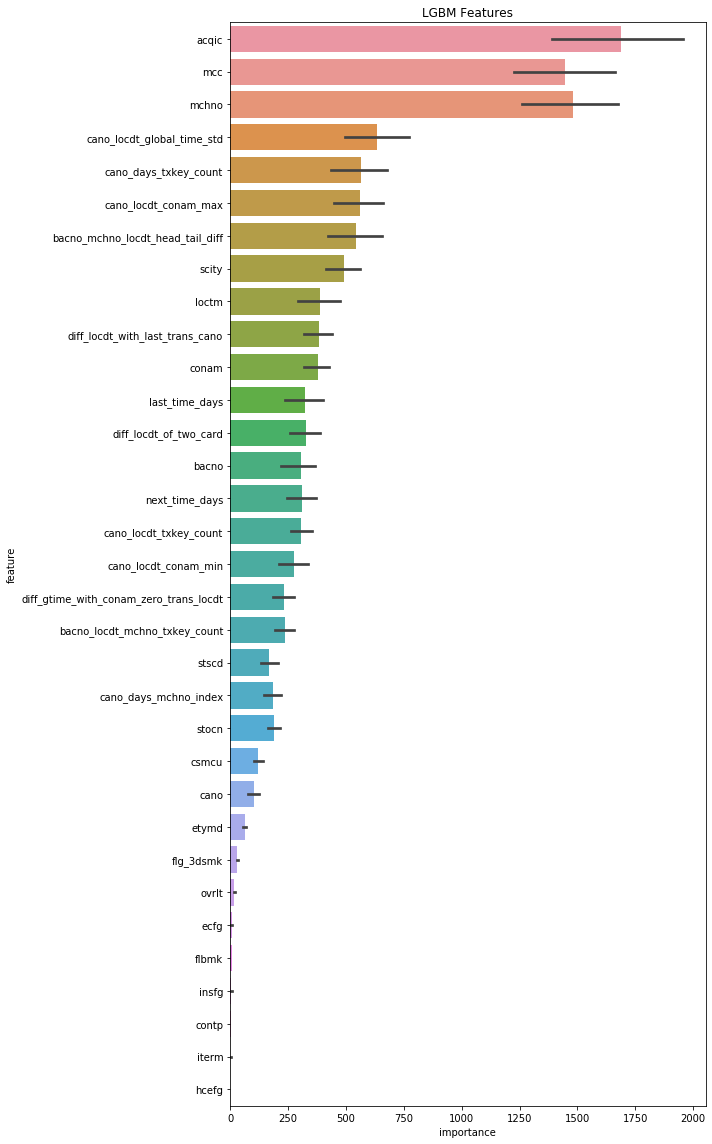

In [9]:
plot_importance(lgbm.df_feature_importance)

In [26]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics

,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,mean,max,min,std,upper_bound_1std,lower_bound_1std
0,0.000026,0.000053,1.702670e-05,0.000048,0.000015,0.000022,8.679415e-06,0.000030,0.000042,0.000019,0.000028,0.000053,8.679415e-06,0.000015,0.000044,1.287913e-05
1,0.000018,0.000016,1.277841e-05,0.000032,0.000028,0.000019,1.731371e-05,0.000057,0.000079,0.000008,0.000029,0.000079,8.407317e-06,0.000024,0.000052,4.971969e-06
2,0.000097,0.000158,8.536300e-05,0.000087,0.000092,0.000108,6.195400e-05,0.000089,0.000036,0.000090,0.000090,0.000158,3.608826e-05,0.000035,0.000126,5.514030e-05
3,0.000010,0.000018,6.540385e-06,0.000021,0.000008,0.000024,1.032669e-05,0.000013,0.000019,0.000014,0.000014,0.000024,6.540385e-06,0.000006,0.000020,8.401752e-06
4,0.000002,0.000004,6.513084e-07,0.000004,0.000001,0.000003,2.302098e-06,0.000003,0.000010,0.000003,0.000003,0.000010,6.513084e-07,0.000003,0.000006,2.977545e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421660,0.014595,0.011508,1.307217e-02,0.013241,0.014967,0.013992,1.631575e-02,0.012232,0.013574,0.012181,0.013568,0.016316,1.150791e-02,0.001539,0.015107,1.202833e-02
421661,0.011844,0.021519,1.459719e-02,0.017489,0.013560,0.012798,1.516507e-02,0.017268,0.013315,0.017279,0.015483,0.021519,1.184431e-02,0.003111,0.018595,1.237209e-02
421662,0.000354,0.001780,3.200192e-04,0.000858,0.000622,0.000341,5.440668e-04,0.000488,0.001525,0.000307,0.000714,0.001780,3.070553e-04,0.000538,0.001252,1.759727e-04
421663,0.000013,0.000023,1.460228e-05,0.000019,0.000023,0.000021,7.763647e-07,0.000029,0.000013,0.000008,0.000016,0.000029,7.763647e-07,0.000009,0.000025,7.543443e-06


In [27]:
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9]

,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,mean,max,min,std,upper_bound_1std,lower_bound_1std
4383,0.147772,0.992668,0.077635,0.988949,0.995039,0.994347,0.988529,0.999589,0.992149,0.999410,0.817609,0.999589,0.077635,0.372263,1.189872,0.445346
4384,0.109055,0.990740,0.077863,0.986632,0.992479,0.993994,0.991361,0.985419,0.992513,0.989056,0.810911,0.993994,0.077863,0.375705,1.186617,0.435206
13550,0.024541,0.928729,0.962274,0.920485,0.946435,0.930541,0.953137,0.921080,0.907445,0.956788,0.845145,0.962274,0.024541,0.328182,1.173327,0.516964
53826,0.003498,0.955200,0.953507,0.896525,0.932631,0.916586,0.003587,0.003803,0.945761,0.941771,0.655287,0.955200,0.003498,0.423170,1.078457,0.232117
53827,0.002641,0.951211,0.968107,0.876686,0.943239,0.900645,0.002326,0.003372,0.945983,0.953801,0.654801,0.968107,0.002326,0.424582,1.079383,0.230219
53828,0.003675,0.947157,0.966913,0.880842,0.953925,0.927128,0.003086,0.005617,0.957464,0.942363,0.658817,0.966913,0.003086,0.425848,1.084664,0.232969
53829,0.004281,0.962018,0.972521,0.884843,0.950296,0.923236,0.003694,0.005707,0.960585,0.946541,0.661372,0.972521,0.003694,0.427368,1.088740,0.234004
53830,0.003990,0.964518,0.976256,0.887253,0.952417,0.929868,0.004835,0.005827,0.961785,0.957896,0.664465,0.976256,0.003990,0.429129,1.093593,0.235336
53831,0.003387,0.950596,0.965779,0.864411,0.945636,0.913115,0.004586,0.005283,0.961133,0.959289,0.657322,0.965779,0.003387,0.425036,1.082358,0.232285
53832,0.003973,0.961100,0.968052,0.884679,0.962472,0.921538,0.003070,0.001854,0.954662,0.966285,0.662768,0.968052,0.001854,0.428939,1.091707,0.233830


# Remove Outier

Since some of the predictions are very extreme, i drop it if the prediction is out of 1 standard deviation boundary.

In [50]:
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9][['mean','mean_remove_outlier']]

,mean,mean_remove_outlier
4383,0.817609,0.993835
4384,0.810911,0.990274
13550,0.845145,0.936324
53826,0.655287,0.934569
53827,0.654801,0.934239
53828,0.658817,0.939399
53829,0.661372,0.942863
53830,0.664465,0.947142
53831,0.657322,0.937137
53832,0.662768,0.945541


In [52]:
df_train['oof_base_model'] = oof_preds_LGBM
df_test['sub_base_model'] = df_sub_preds_statistics['mean_remove_outlier']

# Special Model - Whitelist of Merchant

In [64]:
input_features = features + [special_feautures[0]]
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train['mchno_in_normal_mchno_list'].unique()

array([0, 1])

In [ ]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 10)

Starting LightGBM. Fold 1,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.818412	valid_1's Averge Precision: 0.705703
[200]	training's Averge Precision: 0.85623	valid_1's Averge Precision: 0.722421
[300]	training's Averge Precision: 0.878299	valid_1's Averge Precision: 0.73136
[400]	training's Averge Precision: 0.892896	valid_1's Averge Precision: 0.732535
[500]	training's Averge Precision: 0.904495	valid_1's Averge Precision: 0.735299
[600]	training's Averge Precision: 0.91277	valid_1's Averge Precision: 0.735476
Early stopping, best iteration is:
[513]	training's Averge Precision: 0.905616	valid_1's Averge Precision: 0.735538
Starting LightGBM. Fold 2,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.819335	valid_1's Averge Precision: 0.756673
[200]	training's Averge Precision: 0

In [ ]:
import importlib
import util
importlib.reload(util)
from util.remove_outlier import remove_outlier
